## TEST 55
    Time period	: 1980 - 2008 
    TENSORS
   



In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import rpy2
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")
evgam = importr("evgam")
%load_ext rpy2.ipython

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [3]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

# READ AFI, DJF Temperature and topography FILES

In [4]:
yearb=1980
yeare=2008

files=[f'../AFI/AFI_ERA5_{iyear}_fullUSA_method3.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)
ds=ds.sortby('lat')
ds['AFI']=ds['AFI']*5/9.



return_periods=[2, 5, 10, 25, 50, 100]
Tlon=ds.lon.data
Tlat=ds.lat.data

units='degree-days (°C)'

dsm=xr.open_dataset('../AFI/ERA5_air.2m.DJFclim.nc')
dsm=dsm.drop('season')
dsm=dsm.sortby('lat')
dsm['air']=dsm['air']-273.15
ds=ds.merge({'air':dsm['air']})

dsh=xr.open_dataset('../AFI/ERA5_hgt.sfc.nc')
dsh=dsh.sortby('lat')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/3463782905.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dsm=dsm.drop('season')


# Read GLOST

In [5]:
fileGLOST = '../AFI/NOAA_GLOST_anomaly.csv'
df_glost=pd.read_csv(fileGLOST,skiprows=4)
df_glost['Year']=pd.to_datetime(df_glost['Year'], format='%Y%m')
df_glost=df_glost.rename(columns={'Year': 'time'})

In [6]:
ds_glost=df_glost.set_index(['time']).to_xarray()

In [7]:
def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [8]:
annds_glost=ann_mean(ds_glost)
annds_glost=annds_glost.rename({'year':'time'})
annds_glost=annds_glost.sel(time=ds['time'])

# Merge AFI with GLOST

In [9]:
ds=ds.merge({'glost':annds_glost['Anomaly']})

In [10]:
ds

<xarray.Dataset> Size: 23MB
Dimensions:  (time: 29, lat: 193, lon: 501)
Coordinates:
  * time     (time) int64 232B 1980 1981 1982 1983 1984 ... 2005 2006 2007 2008
  * lat      (lat) float64 2kB 24.0 24.25 24.5 24.75 ... 71.25 71.5 71.75 72.0
  * lon      (lon) float64 4kB 180.0 180.2 180.5 180.8 ... 304.5 304.8 305.0
Data variables:
    AFI      (time, lat, lon) float64 22MB dask.array<chunksize=(1, 193, 501), meta=np.ndarray>
    air      (lat, lon) float64 774kB 22.35 22.34 22.33 ... -18.59 -19.55 -20.88
    glost    (time) float64 232B 0.2895 0.3523 0.1891 ... 0.6623 0.6579 0.5498

# Reduce domain for testing purpose

In [11]:
lon_min=245;lon_max=255
lat_min=28;lat_max=48

In [12]:
ds=ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dsm=dsm.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dsh=dsh.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
Tlon=ds.lon.data
Tlat=ds.lat.data

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/177030950.py:10: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/177030950.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/177030950.py:25: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)


[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

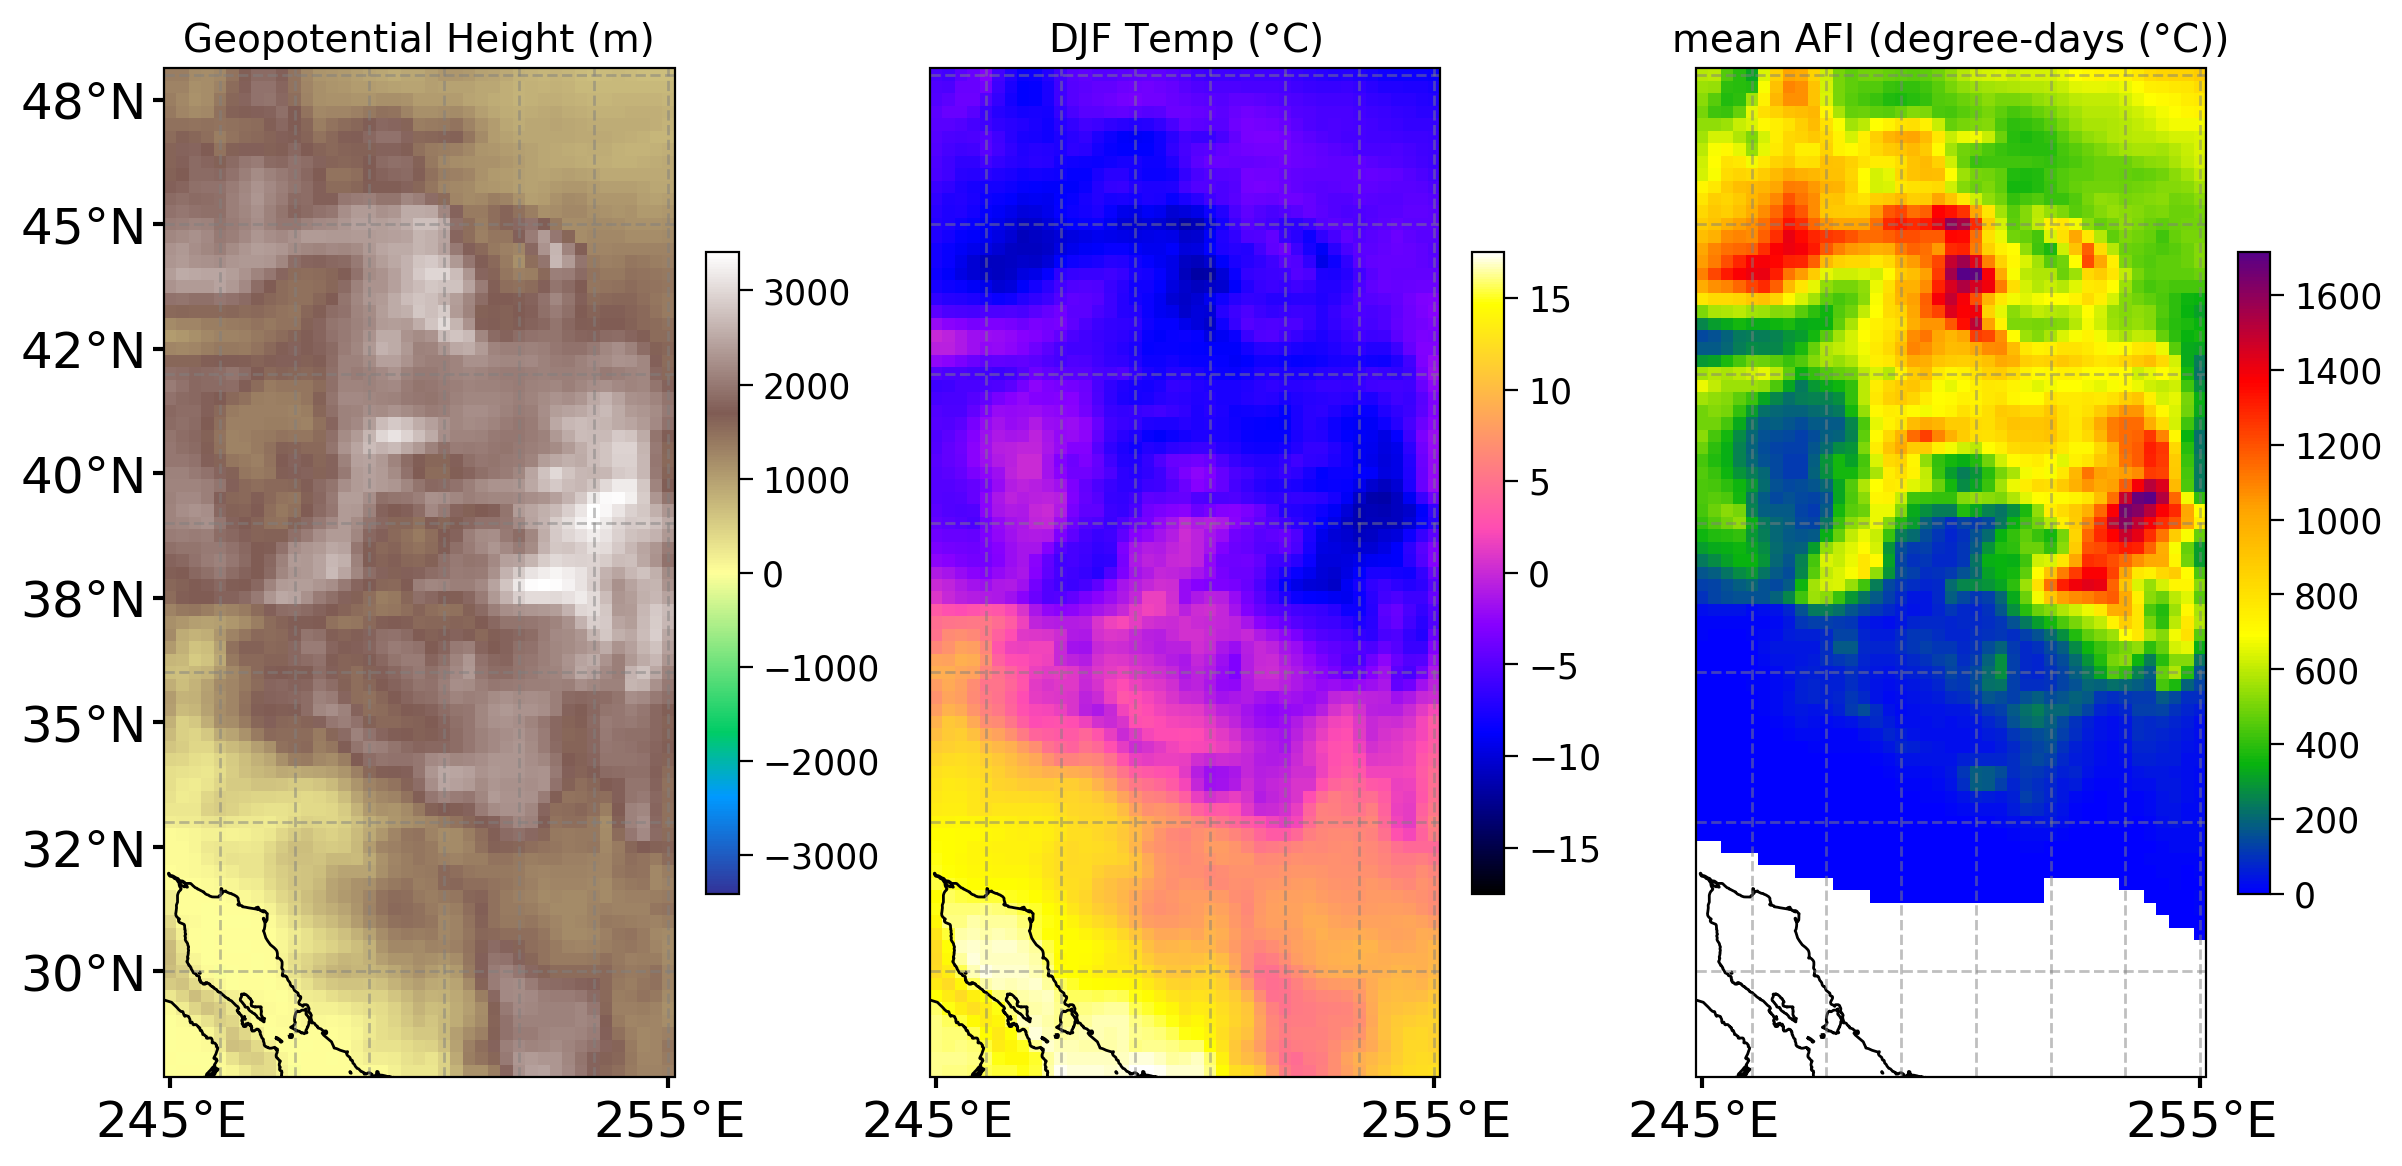

In [13]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

dsh['hgt'].plot(ax=ax[0],cmap='terrain',cbar_kwargs={'label':'','shrink':0.55})
ax[0].set_title('Geopotential Height (m)',fontsize=14)

dsm['air'].plot(ax=ax[1],cmap='gnuplot2',cbar_kwargs={'label':'','shrink':0.55})
ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)

ds['AFI'].mean('time').plot(ax=ax[2],cmap=cmap,cbar_kwargs={'label':'','shrink':0.55})
ax[2].set_title(f'mean AFI ({units})',fontsize=14)

for ix in range(0,len(ax)):
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].coastlines()
  #ax[ix].add_feature(state_borders,zorder=10,linewidth=0.25,edgecolor='k')
  gr=ax[ix].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--',draw_labels=False)
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
ax[0].set_yticks(ax[0].get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax[0].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[0].get_yticks()],size=18)

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/866111733.py:26: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/866111733.py:29: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)


[Text(0, 30.0, '30$\\degree$N'),
 Text(0, 32.5, '32$\\degree$N'),
 Text(0, 35.0, '35$\\degree$N'),
 Text(0, 37.5, '38$\\degree$N'),
 Text(0, 40.0, '40$\\degree$N'),
 Text(0, 42.5, '42$\\degree$N'),
 Text(0, 45.0, '45$\\degree$N'),
 Text(0, 47.5, '48$\\degree$N')]

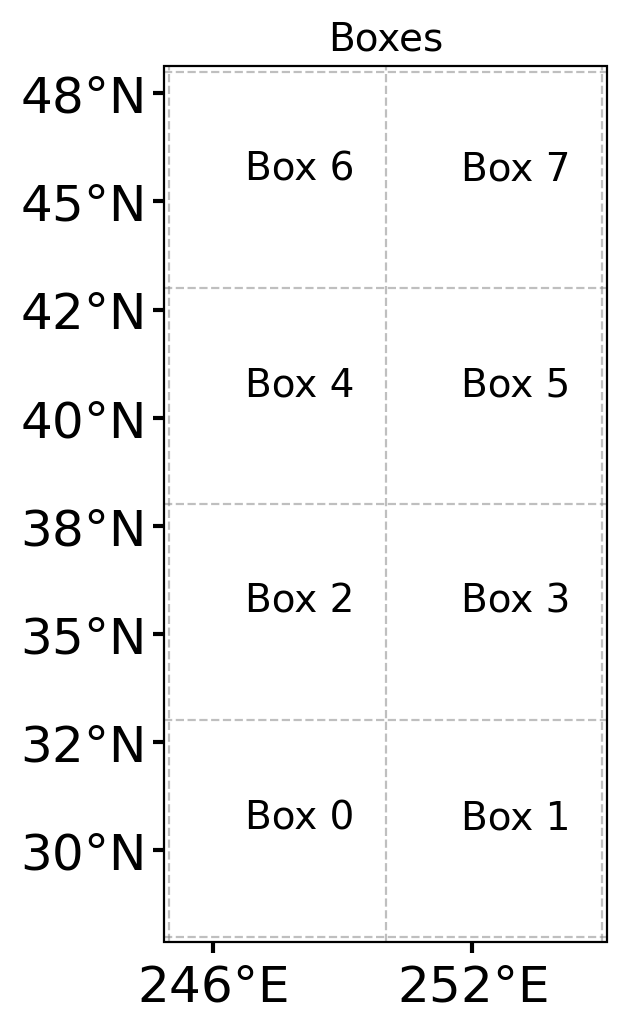

In [14]:
data=dsh['hgt']*np.nan

ib=[7,27,7,27,7,27,7,27]
jb=[10,10,30,30,50,50,70,70]
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

data.plot(ax=ax,add_colorbar=False)
ax.set_title('Boxes',fontsize=14)
for ii in range(0,8):
    ax.text(Tlon[ib[ii]]-360,Tlat[jb[ii]],f'Box {ii}',color='k',size=14)
####
grd = ax.gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)

ax.set_xticks(ax.get_xticks()[1:-1:3],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)

ax.set_yticks(ax.get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)

# Define EVGAM parameters for smoothness 

In [20]:
# parameters for smoothness 
%R fmla_gev <- list(AFI ~ te(lon, lat,air, k=c(1,1,5,5)), ~ te(lon, lat,air, k=c(1,1,5,5)) , ~ 1)

o{'None': AFI ~ te(lon, lat, air, k = c(1, 1, 5, 5))
, 'None': ~te(lon, lat, air, k = c(1, 1, 5, 5))
, 'None': ~1
, }

# evgam fit_gev and rl100
# through box 20x20pts ~6


Stationary, BOX:  0


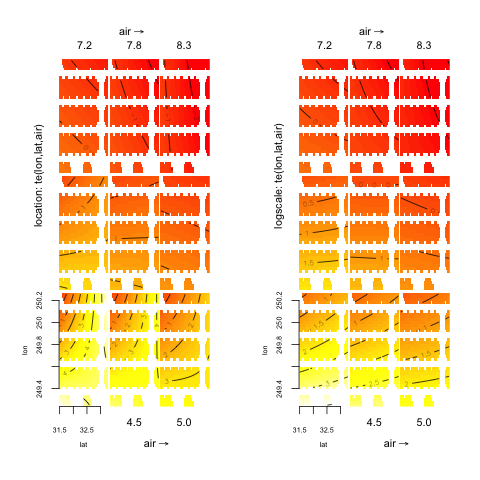

Stationary, BOX:  1


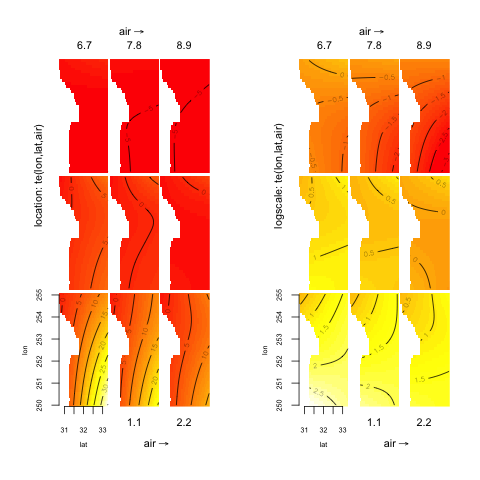

Stationary, BOX:  2


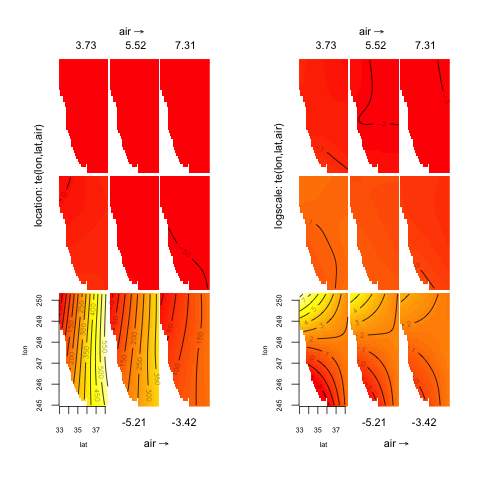

R[write to console]: Final Hessian of negative penalized log-likelihood not numerically positive definite.



Stationary, BOX:  3


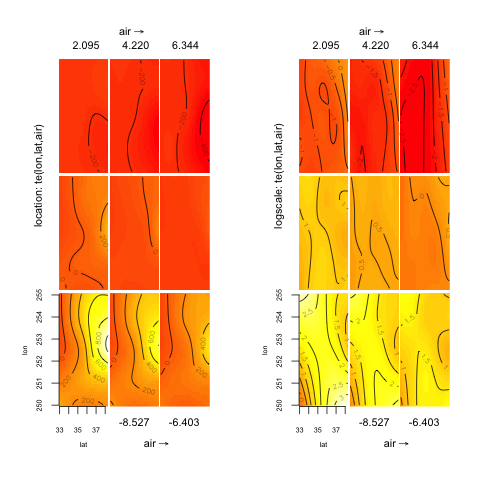

Stationary, BOX:  4


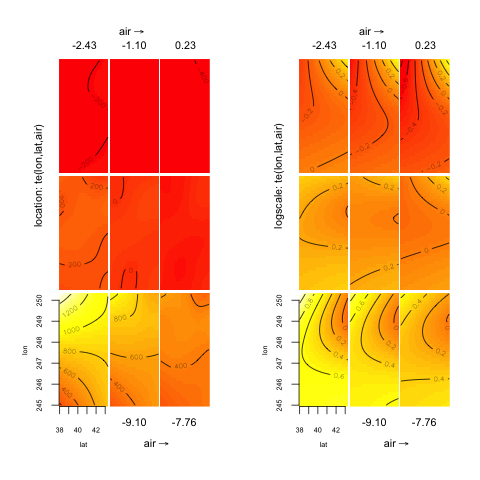

Stationary, BOX:  5


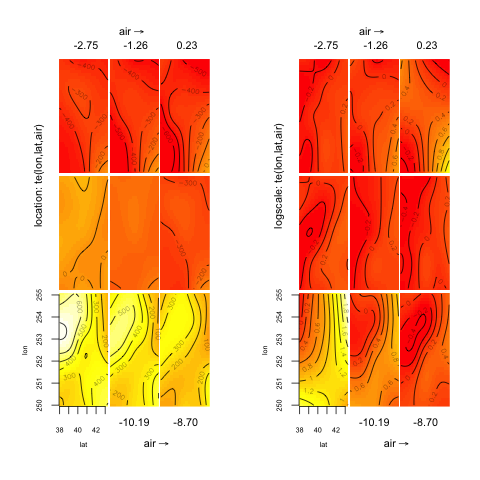

Stationary, BOX:  6


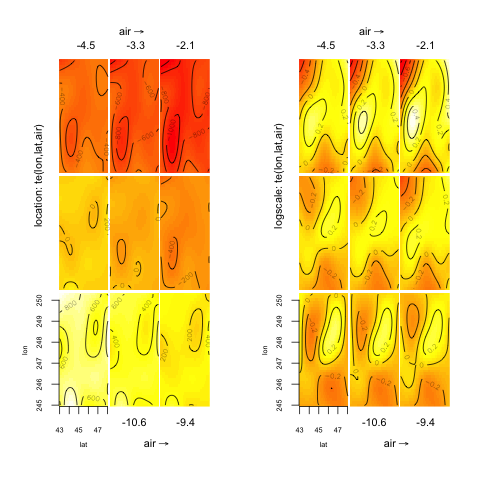

Stationary, BOX:  7


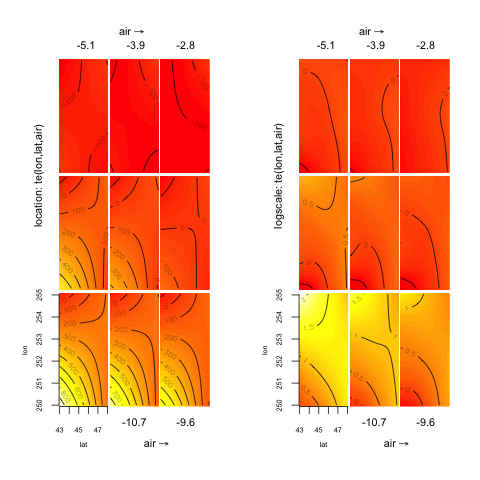

In [21]:
ib=[0,20,0,20,0,20,0,20]
jb=[0,0,20,20,40,40,60,60]


Rlocation=xr.zeros_like(ds['AFI'].load())*np.nan
Rshape=xr.zeros_like(ds['AFI'].load())*np.nan
Rscale=xr.zeros_like(ds['AFI'].load())*np.nan
Rrl100=xr.zeros_like(ds['AFI'].load())*np.nan

for ii in range(0,8): # looop through boxes
  # Extract values for boxes
  dsij=ds.isel(lon=slice(ib[ii],ib[ii]+22),lat=slice(jb[ii],jb[ii]+22)).load()
  dsmij=dsm.isel(lon=slice(ib[ii],ib[ii]+22),lat=slice(jb[ii],jb[ii]+22))
  df = dsij.to_dataframe()
  df = df.reset_index()
  # Remove zeros and NAN 
  # Remove timeseries with less than 15 data (as in Bilotta et al.)
  # Save rows removed
  dfsave=df[(df['AFI'] <= 0.)|(df['AFI'].isna())]
  df = df[df['AFI'] > 0.]

  dfsave=pd.concat([dfsave, df.groupby(['lon', 'lat']).filter(lambda x: len(x) <= 15)])
  df=df.groupby(['lon', 'lat']).filter(lambda x: len(x) > 15)

  # Convert xarray to pandas DataFrame to R data.frame
  # You can now work with 'r_df' in R

  r_df = ro.conversion.py2rpy(df)
  globalenv['r_df'] = r_df

  # EVGAM model fitting  
  %R m_gev <- evgam(fmla_gev, r_df, family = "gev")
  print('Stationary, BOX: ',ii)
  %R plot(m_gev)
  %R gev_pred <- predict(m_gev, r_df, type = "response")
  %R gev_rl100 <- predict(m_gev, r_df, prob = 0.99)
  %R -o gev_pred,gev_rl100 # get R data to python

  # Convert R data.frame to xarray
  gev_pred['lon']=df['lon'].values
  gev_pred['lat']=df['lat'].values
  gev_pred['time']=df['time'].values
  merged=pd.concat([gev_pred,dfsave]) # add time,lon,lat removed
  dsgev_pred=merged.set_index(['time','lat','lon']).to_xarray()

  ###


  ######
  ######
  gev_rl100['lon']=df['lon'].values
  gev_rl100['lat']=df['lat'].values
  gev_rl100['time']=df['time'].values
  merged=pd.concat([gev_rl100,dfsave]) # add time,lon,lat removed
  dsgev_rl100=merged.set_index(['time','lat','lon']).to_xarray()

  ######

    
  ######
  ######
  Rlon = dsgev_pred['lon'][1:21]
  Rlat = dsgev_pred['lat'][1:21]
  Rtime= dsgev_pred['time']

  ######
  # Save boxes data 
  # and remove of lon_edges  
  Rlon = dsgev_pred['lon'][1:21]
  Rlat = dsgev_pred['lat'][1:21]
  Rlocation.loc[{'time':Rtime,'lat':Rlat,'lon':Rlon}]=dsgev_pred['location'][:,1:21,1:21]
  Rscale.loc[{'time':Rtime,'lat':Rlat,'lon':Rlon}]=dsgev_pred['scale'][:,1:21,1:21]
  Rshape.loc[{'time':Rtime,'lat':Rlat,'lon':Rlon}]=dsgev_pred['shape'][:,1:21,1:21]
  Rrl100.loc[{'time':Rtime,'lat':Rlat,'lon':Rlon}]=dsgev_rl100['q:0.99'][:,1:21,1:21]


boxes in grey

# Read GEV parameters with scipy.stats.

In [22]:

file0=f'../AFI/afi_return.fullUSA.gev.1980_2008_KS.nc'
ds0=xr.open_dataset(file0)
ds0=ds0.sortby('lat')
ds0=ds0.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

Slocation = ds0['location']*5/9.
Sshape = ds0['shape']
Sscale = ds0['scale']*5/9.
Srl100 = ds0['return_afi'].sel(return_periods=100)*5/9.


# Difference between the 3 methods: evgam , evgam Non Stationnary, Scipy

The 100-year return level is expressed in degree-days (C).

<>:61: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:61: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/810324752.py:61: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_94994/810324752.py:66: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)


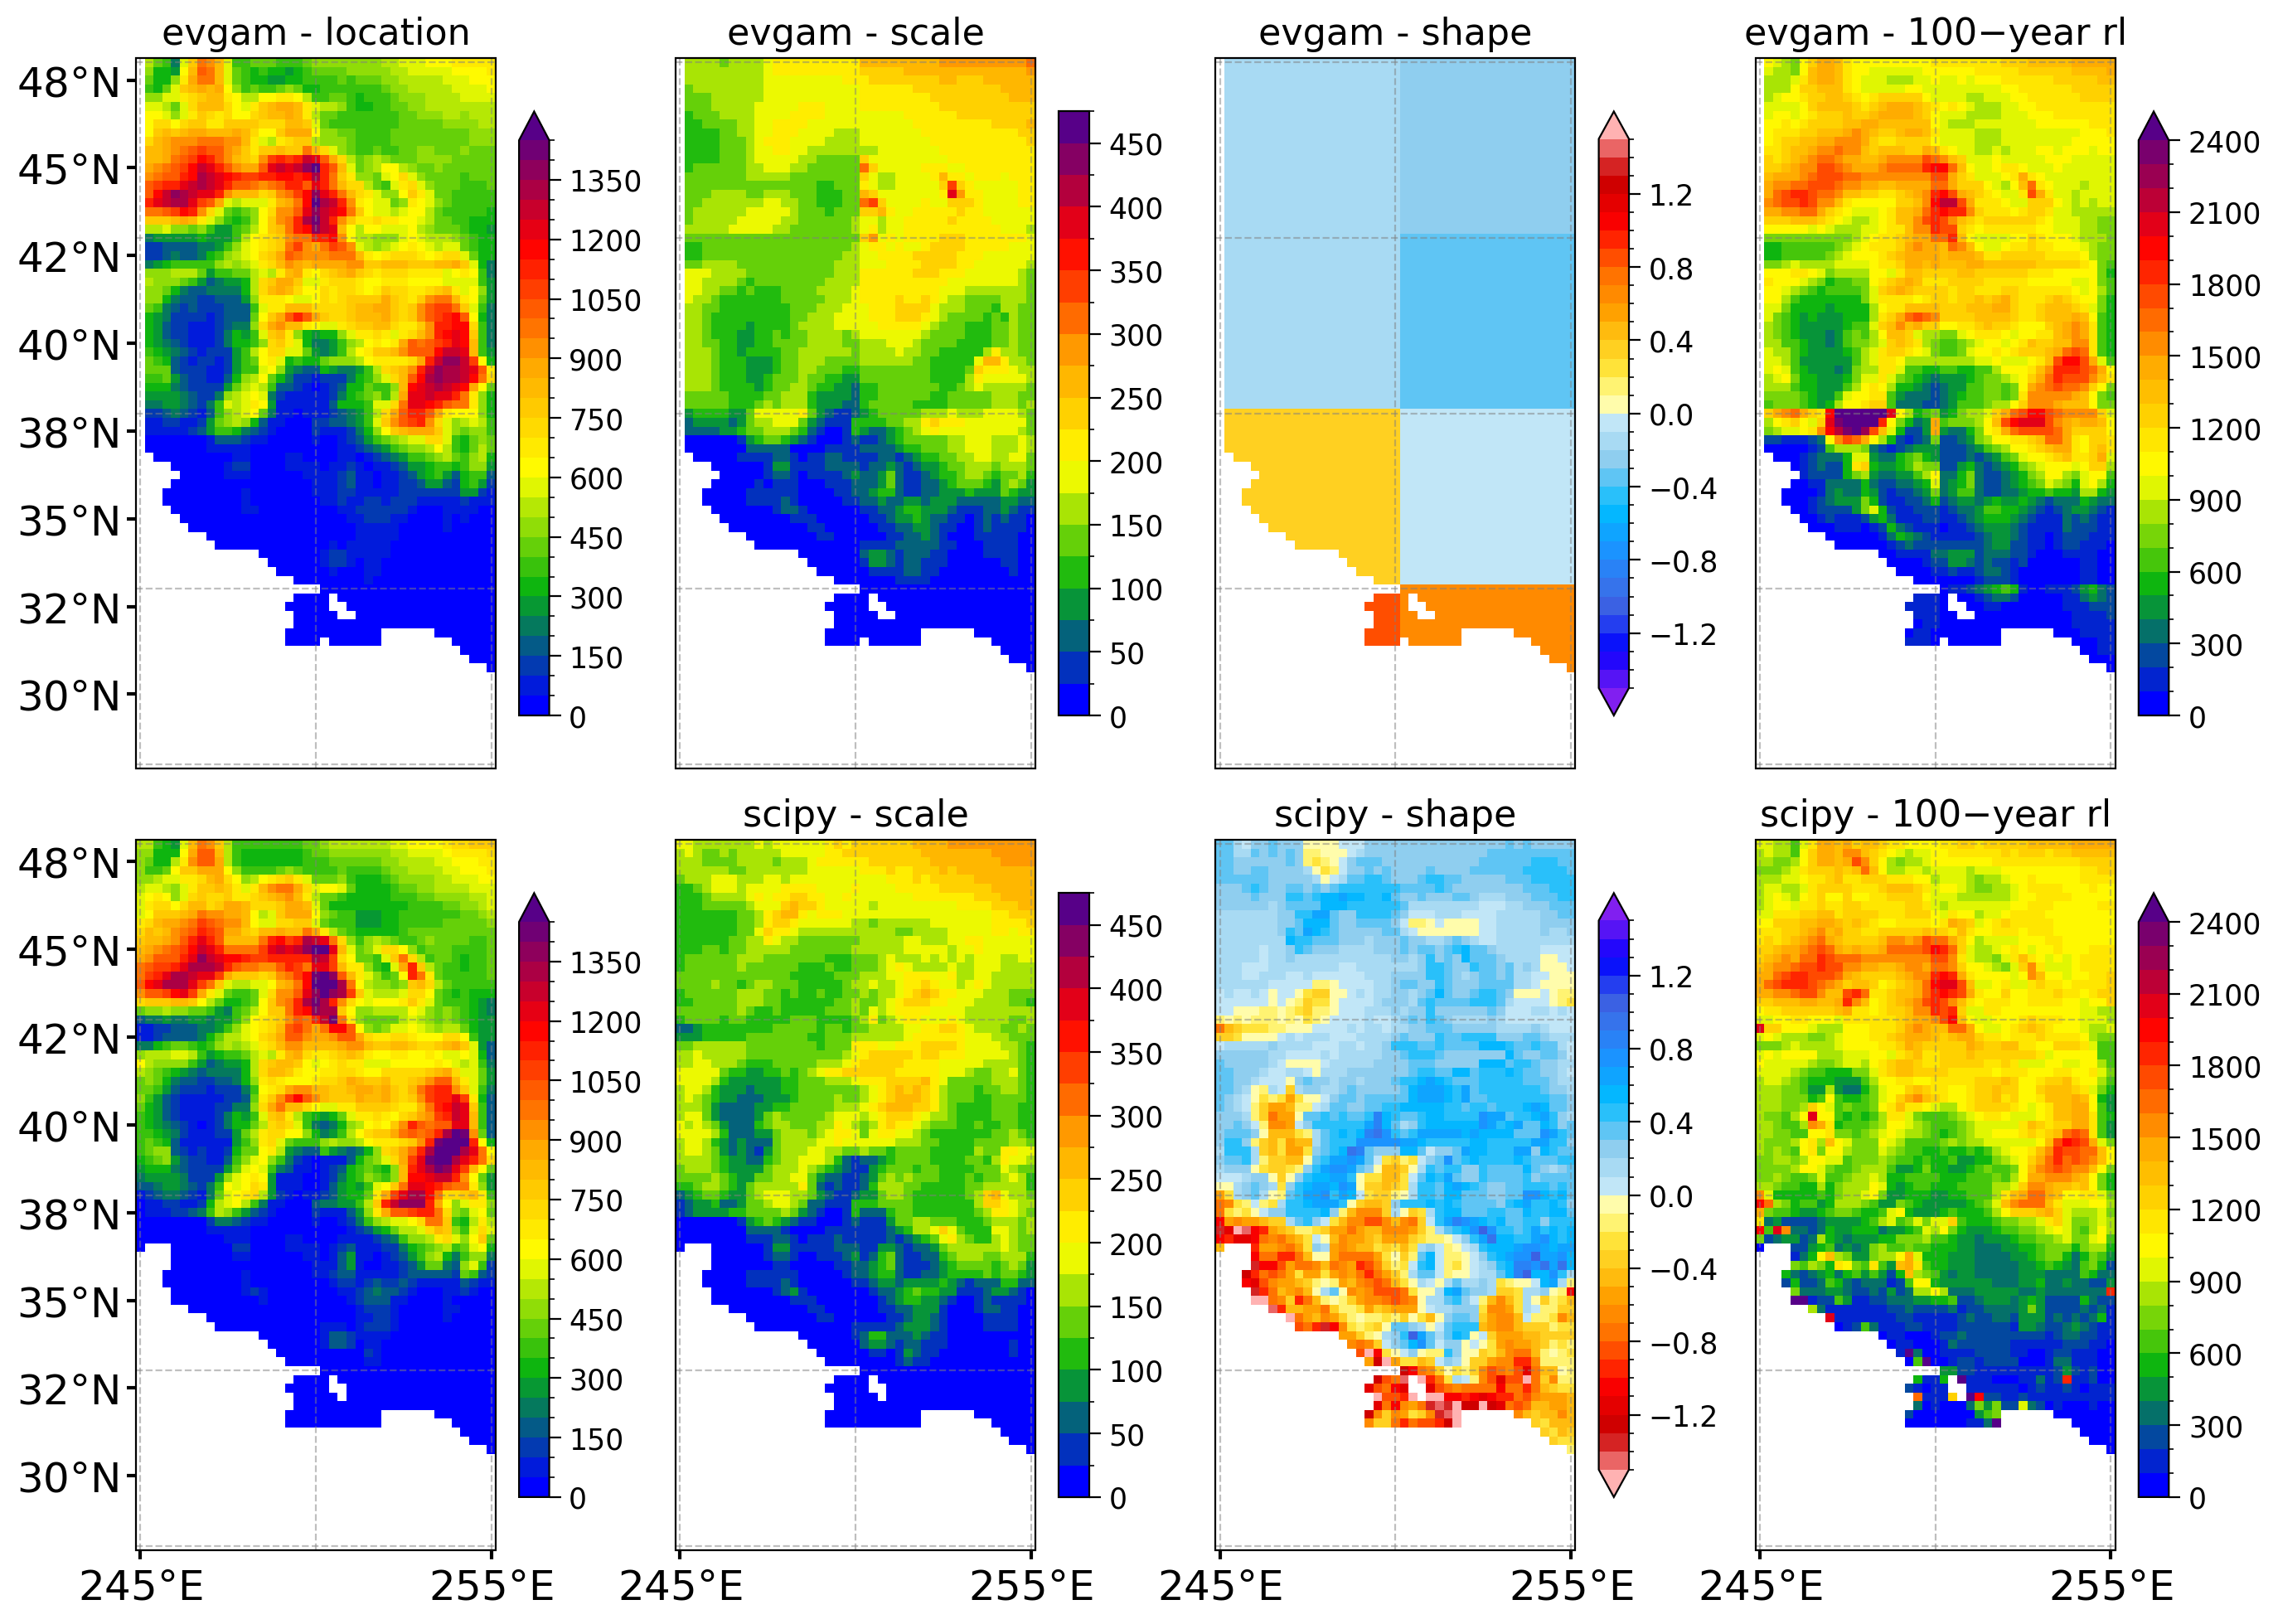

In [23]:

proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(14,10),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.05,top=0.95, left=0.05,right=0.95,wspace=0.15,hspace=0.1)
ax=ax.flatten()

shrink=0.85
#
#  Location
#
clevs = np.arange(0,1500,50)

Rlocation.mean('time').plot(ax=ax[0],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[0].set_title('evgam - location',fontsize=16)

Slocation.plot(ax=ax[4],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].set_title('scipy - location',fontsize=16)
#
#
#  Scale
#
clevs = np.arange(0,500,25)

Rscale.mean('time').plot(ax=ax[1],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].set_title('evgam - scale',fontsize=16)

Sscale.plot(ax=ax[5],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[5].set_title('scipy - scale',fontsize=16)
#
#  Shape
#
clevs = np.arange(-1.5,1.6,0.1)

Rshape.mean('time').plot(ax=ax[2],cmap=cmaps.ncl_default,levels=clevs,extend='both',cbar_kwargs={'label':'','shrink':shrink})
ax[2].set_title('evgam - shape',fontsize=16)

Sshape.plot(ax=ax[6],cmap=cmaps.ncl_default_r,levels=clevs,extend='both',cbar_kwargs={'label':'','shrink':shrink})
ax[6].set_title('scipy - shape',fontsize=16)
#
#  RL100
#
clevs = np.arange(0,2500,100)

Rrl100.mean('time').plot(ax=ax[3],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[3].set_title('evgam - 100−year rl',fontsize=16)

Srl100.plot(ax=ax[7],cmap=cmaps.BlGrYeOrReVi200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[7].set_title('scipy - 100−year rl',fontsize=16)
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    xlocs=[Tlon[0]-360,Tlon[20]-360,Tlon[40]-360], 
    ylocs=[Tlat[0], Tlat[20], Tlat[40],Tlat[60],Tlat[80]], 
    color='gray', alpha=0.5, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  if ix > 3: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('')  
  if (ix==0) |(ix==4) | (ix==8)|(ix==12):  
    ax[ix].set_yticks(ax[ix].get_yticks()[1:-1],crs=ccrs.PlateCarree())
    ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
outfile=f'GEV_parameters_test521.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')


Due to inverse sign between the R-shape and scipy-shape parameters the colorbar is inverse for the scipy - shape plot.